In [87]:
import pandas as pd
import numpy as np
import json
import requests
import boto3
from sklearn.preprocessing import StandardScaler
import datetime
from typing import Dict, List


def get_cloud_cover(x):
    try:
        return x[0]["amount"]
    except:
        return None


features = [
    "properties.elevation.value",
    "properties.windSpeed.value",
    "properties.precipitationLastHour.value",
    "properties.temperature.value",
    "properties.relativeHumidity.value"
    #'properties.cloudLayers'
]

relative humidity = f(temperature, wind speed, cloud cover, elevation)


In [16]:
s3 = boto3.client("s3")
fc = s3.get_object(Bucket="cw-weather-data", Key="observations/OHZ055_2023-08-08.json")
file_content = fc["Body"]
dd = json.load(file_content)
df = pd.json_normalize(dd, record_path="features")

In [17]:
def columnNameReformat(column_name: str) -> str:
    """Reformats a column name for easier use in applications."""
    column_name = column_name.lower()
    column_name = column_name.replace("properties", "")
    column_name = column_name.replace(".", "_")
    column_name = column_name.strip()
    return column_name


def preprocessQuant(feature) -> np.array:
    """Processes a quantiative feature for input to an ML algorithm"""
    # scaler = StandardScaler()
    x = np.array(feature)
    np.nan_to_num(x, copy=False)
    # x_tran = scaler.fit_transform(x.reshape(-1,1))
    return x


def featureDict(
    start: datetime.datetime, feature_name: str, feature_data: List
) -> Dict:
    """Creates a python Dict object for a feature with a given start date."""

    return dict(
        {
            "start": start,
            feature_name: feature_data.reshape(1, len(feature_data))[0].tolist(),
        }
    )


def getStart(df: pd.DataFrame) -> str:
    """Gets the start date for the input data from the dataframe."""
    # sort the dataframe by the measurement time
    return df.index[0]


def getStartString(df: pd.DataFrame) -> str:
    """Gets the start date in a string format"""
    stp = datetime.datetime.strptime(
        df["properties.timestamp"][0], "%Y-%m-%dT%H:%M:%S%z"
    )
    return datetime.datetime.strftime(stp, "%Y-%m-%d %H:%M:%S")


def preprocessDataFrame(df: pd.DataFrame) -> pd.DataFrame:
    """Processes the dataframe."""

    stp = df["properties.timestamp"].apply(
        lambda x: datetime.datetime.strptime(x, "%Y-%m-%dT%H:%M:%S%z")
    )

    # set the index
    df.index = stp

    # sort the dataframe by the index
    df.sort_index(inplace=True)

    # rename index
    df.index.name = "timestamp"

    return df


def write_dicts_to_file(path, data):
    with open(path, "wb") as fp:
        for d in data:
            fp.write(json.dumps(d).encode("utf-8"))
            fp.write("\n".encode("utf-8"))

In [18]:
# df is the
preprocessed_df = preprocessDataFrame(df)
start = getStart(preprocessed_df)
start_str = getStartString(preprocessed_df)

mylist = list()

for feature in features:
    mylist.append(
        featureDict(
            start_str,
            columnNameReformat(feature),
            preprocessQuant(preprocessed_df[feature]),
        )
    )

write_dicts_to_file("data.json", mylist)

In [38]:
y = df[features[-1]]

In [39]:
X = df[features[:-1]]

In [48]:
scaler = StandardScaler()
X.fillna(0, inplace=True)

scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features[:-1]

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

In [74]:
model = RandomForestRegressor()

In [75]:
y.fillna(0, inplace=True)

In [76]:
model.fit(X, y)

RandomForestRegressor()

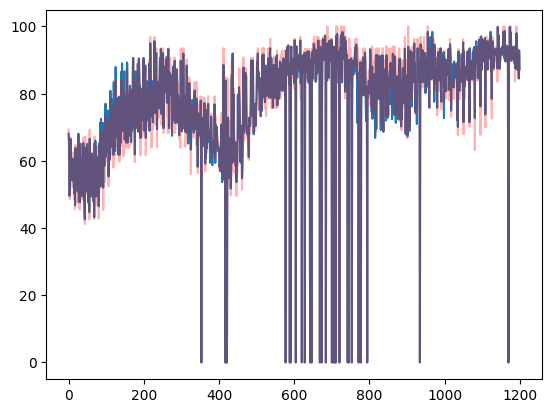

In [86]:
import matplotlib.pyplot as plt

plt.plot(model.predict(X))
plt.plot(y_no_index, alpha=0.3, color="r")

In [69]:
y_no_index = y.values